In [1]:
%matplotlib inline
import sys
sys.path.append("../../../agnpy")
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from agnpy.emission_regions import Blob
from astropy.coordinates import Distance
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk

# electron densities

In [5]:
spectrum_norm = 1e-2 * u.Unit("cm-3")
parameters = {
    "p1": 2.0001,
    "p2": 3.5,
    "gamma_b": 1e4,
    "gamma_min": 20,
    "gamma_max": 5e7,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
R_b = 1e16 * u.cm
B = 0.56 * u.G
z = 1
delta_D = 40
Gamma = 40
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
blob.set_gamma_size(800)

normalising broken power-law to total particle density: 1.00e-02 1 / cm3


In [6]:
from jetset.jet_model import Jet
jet = Jet(name='test',electron_distribution='bkn')
jet.set_par('B',val=blob.B.value)
jet.set_par('N',val=blob.n_e_tot.value)
jet.set_par('R',val=np.log10(blob.R_b.value))
jet.set_par('beam_obj',val=blob.delta_D)
jet.set_par('gmin',val=blob.gamma_min)
jet.set_par('gmax',val=blob.gamma_max)
jet.set_par('gamma_break',val=blob.n_e.gamma_b)
jet.set_par('p',val=blob.n_e.p1)
jet.set_par('p_1',val=blob.n_e.p2)
jet.set_par('z_cosm',val=blob.z)
jet.set_gamma_grid_size(1000)
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +5.600000e-01 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000170e-02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 beam_obj         | beaming              |                  | +4.000000e+01 | [+1.000000e+00,No           ] | False 
 gamma_break      | turn-over-energy     | Lorentz-factor   | +1.000000e+04 | [+1.000000e+00,+1.000000e+08] | False 
 gmax             | high-energy-cut-off  | Lorentz-f

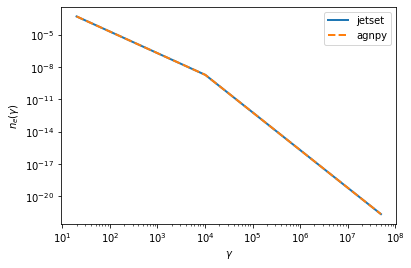

total density 1.00e-02 1 / cm3
total energy 4.72e+42 erg


In [7]:
plt.loglog(jet.electron_distribution.gamma, jet.electron_distribution.n_gamma, lw=2, label="jetset")
plt.loglog(blob.gamma, blob.n_e(blob.gamma), lw=2, ls="--", label="agnpy")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$n_e(\gamma)$")
plt.legend()
plt.show()
print(f"total density {blob.n_e_tot:.2e}")
print(f"total energy {blob.W_e:.2e}")

In [10]:
# disk parameters
M_sun = const.M_sun.cgs
M_BH = 1.2 * 1e9 * M_sun
R_g = ((const.G * M_BH) / (const.c * const.c)).cgs
L_disk = 2 * 1e46 * u.Unit("erg s-1")
eta = 1 / 12
R_in = 6 * R_g
R_out = 200 * R_g
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
ec = ExternalCompton(blob, disk, r=1e17*u.cm)

In [19]:
jet.add_EC_component("EC_Disk")
jet.set_par("L_Disk", val=disk.L_disk.value)
jet.set_par("R_ext_Sw", val=200)
jet.set_par("R_inner_Sw", val=6)
jet.set_par("accr_eff", val=disk.eta)
jet.set_par("R_H", val=1e17)
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +5.600000e-01 | [+0.000000e+00,No           ] | False 
 L_Disk           | Disk                 | erg/s            | +2.000000e+46 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000170e-02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 R_H              | Disk                 | cm               | +1.000000e+17 | [+0.000000e+00,No           ] | False 
 R_ext_Sw         | Disk                 | Sw. radii

In [20]:
nu_jetset, sed_jetset = jet.get_SED_points(name="EC_Disk")

In [21]:
nu_agnpy = np.logspace(17, 30) * u.Hz
sed_agnpy = ec._sed_flux_disk(nu)

NameError: name 'ec' is not defined